Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
y[8:13], x[8:13] = [329 330 334 335 335] [120 126 126 120 125]
y[8:13], x[8:13] = [329 330 334 335 335] [120 126 126 120 125]


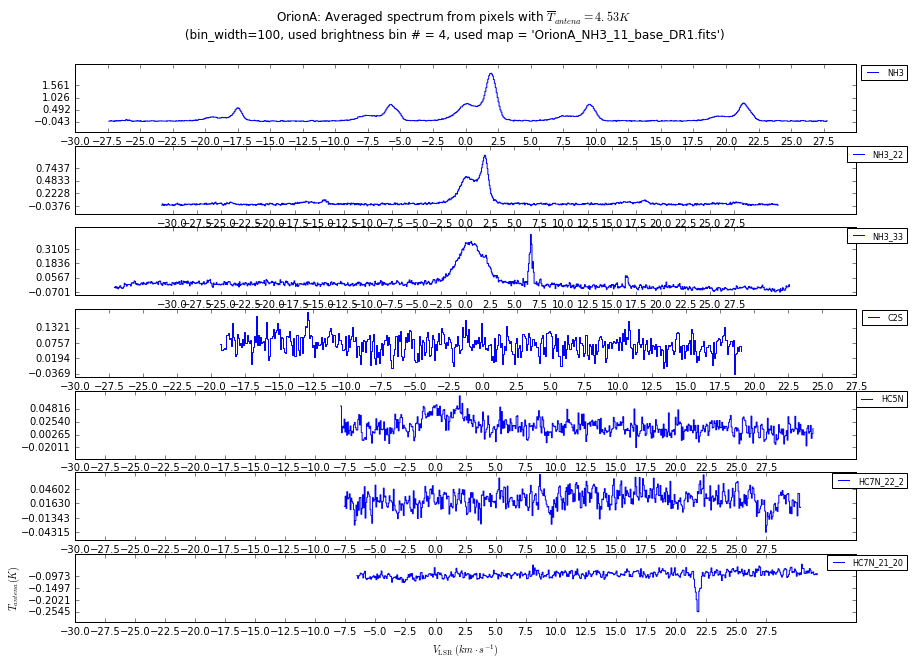

y[8:13], x[8:13] = [330 330 330 330 331] [122 123 124 125 120]
y[8:13], x[8:13] = [334 340 341 341 342] [124 119 119 120 118]
y[8:13], x[8:13] = [334 334 335 335 339] [120 125 122 123 119]
y[8:13], x[8:13] = [335 338 339 340 340] [124 120 121 118 121]
y[8:13], x[8:13] = [330 330 330 330 331] [122 123 124 125 120]
y[8:13], x[8:13] = [334 340 341 341 342] [124 119 119 120 118]
y[8:13], x[8:13] = [334 334 335 335 339] [120 125 122 123 119]
y[8:13], x[8:13] = [335 338 339 340 340] [124 120 121 118 121]
t['T_med']= T_med
-----
 9.71
  7.3
 5.82
  5.1


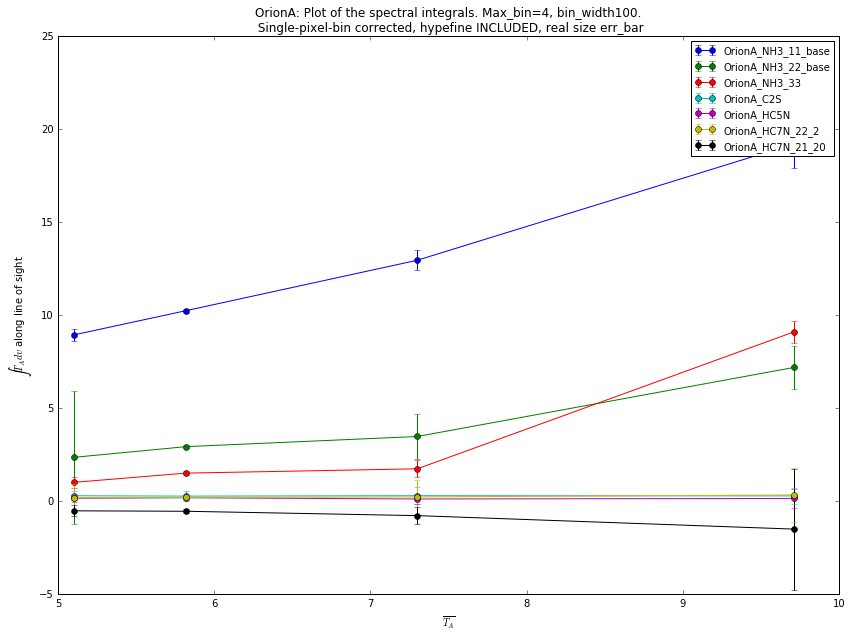

map,bin width,bin#,T_med,OrionA_NH3_11_base,OrionA_NH3_11_base_err,OrionA_NH3_22_base,OrionA_NH3_22_base_err,OrionA_NH3_33,OrionA_NH3_33_err,OrionA_C2S,OrionA_C2S_err,OrionA_HC5N,OrionA_HC5N_err,OrionA_HC7N_22_2,OrionA_HC7N_22_2_err,OrionA_HC7N_21_20,OrionA_HC7N_21_20_err
str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
OrionA_NH3_11_base_DR1.fits,100.0,0.0,9.71,19.2118937488,1.30303965687,7.19680475092,1.17012279615,9.10722449541,0.612969416729,0.290895830434,0.446916911901,0.154784274082,0.497310606403,0.341675626992,1.42719043268,-1.49308156446,3.25624645694
OrionA_NH3_11_base_DR1.fits,100.0,1.0,7.3,12.9615414803,0.529882509124,3.48521843576,1.22253281855,1.74766886196,0.460558044378,0.303754769946,0.444387907513,0.126431324615,0.269149935356,0.236853997044,0.923590185627,-0.768358611565,0.451469872122
OrionA_NH3_11_base_DR1.fits,100.0,2.0,5.82,10.2511032325,0.101825751672,2.9394411567,0.0974519448532,1.51639261756,0.122704716815,0.280250618586,0.272629547701,0.191497862887,0.113019047238,0.209399644541,0.156445083089,-0.534591609929,0.0991721666322
OrionA_NH3_11_base_DR1.fits,100.0,3.0,5.1,8.94427545611,0.330436537519,2.36372480131,3.59415604357,1.01927015386,0.284803309827,0.29986372232,0.2541196119,0.164521977575,0.216493675585,0.189789909341,0.718489755599,-0.509775515822,0.29916714484


In [7]:
# What are the variables we want set as default?
# Taking out the user input leaves much less comparison options? what do we want to compare actually?
# Now bin_width=500, wanted_bin=0 occure as kew words in main() and in binning() function. Is this OK?
# Do we want to have global variable declarations in the header?


import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

%pylab
%matplotlib inline

vlsr = fits.getdata('OrionA_NH3_11_base_DR1_mom1.fits')
files =['OrionA_NH3_11_base_DR1.fits', 'OrionA_NH3_22_base_DR1.fits', 'OrionA_NH3_33_DR1.fits',
       'OrionA_C2S_DR1.fits','OrionA_HC5N_DR1.fits', 'OrionA_HC7N_22_21_DR1.fits', 
        'OrionA_HC7N_21_20_DR1.fits'] #, 'OrionA_NH3_33_DR1_wts.fits'


bin_width = 100
this_bin = 4
# map_name = 'NGC1333_Temperature.fits'
map_name = 'OrionA_NH3_11_base_DR1.fits'
map_binning = 'OrionA_NH3_11_base_DR1_mom0.fits'

def main(this_bin, bin_width):   
    # This is the main routine.
    y, x, med = binning(map_name, bin_width, this_bin)
    
    plot_spectra(this_bin, bin_width)
    t, table_names = make_table(files, map_name, this_bin, bin_width, y, x)
    plot_table(files, map_name, this_bin, bin_width, y, x)
    return t

def plot_spectra(this_bin, bin_width):
    loop_count = 0
    fig = plt.figure(figsize=(14,10))
    # for plotting plots in a single figure put plt.figure before all the .plot commands
    # otherwise you will get the plots in a different figures
    
    y, x, med = binning(map_name, bin_width, this_bin)
    # This takes in a 2D map and returns a 2D map where the image values are the bin to which a pixel belongs.
    
    for file_name in files:            
        sp_av, cube = averaging(file_name, y, x)
        thiscube_spectrum_dv, cube, offset_velocity = averaging_over_dopplervel(file_name, y, x)
        #Change to velocity axis and such here as well.  Then average all spectra with that bin label.
        ax = fig.add_subplot(len(files),1,loop_count+1)
        plt.plot(offset_velocity,thiscube_spectrum_dv, drawstyle='steps')
        plt.yticks(np.arange(min(thiscube_spectrum_dv), max(thiscube_spectrum_dv), (max(thiscube_spectrum_dv)-min(thiscube_spectrum_dv))/4)) 
        plt.xticks(np.arange(-30, 30, 2.5)) 
    
#         if file_name != files[-1]:
#             plt.setp(ax.get_xticklabels(), visible=False)

        file_name = file_name.strip('L1455_').strip('_all.fits').strip('NGC1333').strip('_DR1_all.fits').strip('OrionA_').strip('_base_DR1.fits')
        plt.legend([file_name], bbox_to_anchor=(1.07, 1.05), prop={'size':8})
        
        loop_count += 1        

#     plt.legend(leg, loc = 5, prop={'size':8})
#     ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
#     fig.legend(curves_names, leg, bbox_to_anchor=(0.5, -0.15))
#     figtext(.1,.0,'averaging over brightness, with doppler v correction, thisbin=2' , fontsize=8)
#     fig.suptitle("averaging over brightness with brightnes bin = %r for bin width = %r" %(this_bin, bin_width), fontsize=12)
    fig.suptitle("OrionA: Averaged spectrum from pixels with $\overline{T}_{antena} = %rK$ \n (bin_width=%r, used brightness bin # = %r, used map = %r)"
                 %(med, bin_width, this_bin, map_name), fontsize=12)
    plt.ylabel(r'$T_{antena} (K)$')
    plt.xlabel(r'$V_{\mathrm{LSR}}\ (km \cdot s^{-1})$')
    plt.savefig("OrionA:BinsAveraging_bin_width=%rthis_bin=%r.ps" %(bin_width, this_bin))
    plt.show()

      
def binning(map_name, bin_width, this_bin):
    """A function creating brightness bins of pixels, and eventualy a map, in the given spectral cube"""
#     cube = SpectralCube.read(map_name)
#     cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
#     Tmax = cube.apply_numpy_function(np.nanmax,axis=0) # array of the maximum values in the spectra of each pixel
#     baddata = nd.morphology.binary_dilation(np.isnan(Tmax),np.ones((25,25)))
#     Tmax[baddata]=0.0
#     Tmax[np.isfinite(Tmax)]
    
    Tmax = fits.getdata(map_binning)
    bin_arr = np.sort(Tmax[np.isfinite(Tmax)])
    bin_arr2 = bin_arr[:: - bin_width] # this creates an array of the bin margins, in which every bin has a width of "bin_width"  
    bins = np.digitize(Tmax,bin_arr2)
#     print 'old bins =', bins
    bins = [x-1 for x in bins] # this and the following line correct the fact that there is otherwise
    bins = np.array(bins) # only one pixel in the bin = 0
#     print type(bins)
#     print 'bins =', bins
    y, x = np.where(bins==this_bin)
    print 'y[8:13], x[8:13] =', y[8:13], x[8:13]
    med = round(np.median(Tmax[y,x]), 2)
#     print 'med in binning():', med
    return y, x, med

def averaging(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    return sp_av, cube

def averaging_over_dopplervel(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    thiscube_spectrum_dv, offset_velocity = GAS.gasBinning.BinByMask(cube, CentroidMap = vlsr, x = x, y = y)
    return thiscube_spectrum_dv, cube, offset_velocity


def make_table(files, map_name, this_bin, bin_width, y, x):
    # approach: first loop - make all the columns, with names. First columns will contain all the same data,
    # last ones would be empty.
    # second loop - append all the rows with the data
    
    # Or, create an empty tables. Then create in a loop all the rows. At the end of the loop add the rows
    # to the table. Then just add region, map and bin_width
    # in the title
        
#     table_names = ['map', 'bin width', 'bin#', 'T_med'] + [f.strip('NGC1333').strip('_DR1_all.fits') for f in files]
    table_names = ['map', 'bin width', 'bin#', 'T_med']
    for f in files:
        table_names.append(f.strip('NGC1333').strip('_DR1_all.fits'))
        table_names.append(f.strip('NGC1333').strip('_DR1_all.fits')+'_err')
        
    arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))    
    t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8'])    
    for bin_num in range(this_bin):
        y, x, med = binning(map_name, bin_width, bin_num)
        row = [map_name, bin_width, bin_num, med]
        for file_name in files:
            thiscube_spectrum_dv, cube, offset_velocity = averaging_over_dopplervel(file_name, y, x)
            sp_integral, error_bar = spectral_integral_and_err(offset_velocity, thiscube_spectrum_dv, cube, file_name)
            row.append(sp_integral)
            row.append(error_bar)
        t[bin_num] = row
    
#     t.write('filename.txt', format='latex') # - COOL!!!
#     t.write('NGC1333_bin_width=%r_MaxBin#=%r_no_header.txt' %(bin_width, this_bin), format='ascii.no_header')
#     t.write('OrionA:Table_spec_integrals_corrected_bin_width=%r_MaxBin#=%r_HYPERFINE.txt' %(bin_width, this_bin), format='ascii.fixed_width')
    return t, table_names


def plot_table(files, map_name, this_bin, bin_width, y, x):
    t, table_names = make_table(files, map_name, this_bin, bin_width, y, x)
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(111)
    ax1.set_title("OrionA: Plot of the spectral integrals. Max_bin=%r, bin_width%r.\n Single-pixel-bin corrected, hypefine INCLUDED, real size err_bar"%(this_bin, bin_width))    
    ax1.set_xlabel('$\overline{T_A}$')
    ax1.set_ylabel('$\int T_A dv$ along line of sight')    
    
    print "t['T_med']=", t['T_med']
    for file_name in files:
        column_name = file_name.strip('NGC1333').strip('_DR1_all.fits') 
        ax1.errorbar(t['T_med'], t[column_name], yerr=t[column_name+'_err'], marker='o', linestyle='-', label=str(column_name))
        
        
    leg = ax1.legend(prop={'size':10})
    
#     plt.errorbar(t['T_med'], t[column_name], yerr=y_error)
#     plt.savefig("OrionA:SpeclInteg_CORRECTED_bin_width=%rthis_bin=%r_HYPERFINE.png" %(bin_width, this_bin))
    plt.show()
    
    
def spectral_integral_and_err(offset_velocity, thiscube_spectrum_dv, cube, file_name):
    # first, calculating the integral
    lines_margins = {'NH3_11': [[-1.5, 3.],[6.25, 11.],[18.5,22.5], [-8.5,-4.5], [-21., -16.5]], 'NH3_22': [[-2., 3.], [-17., -13.5], [15.5, 19.]],
                 'NH3_33': [[-4.25, 4]], 'C2S': [[-1.5, 3.]], 'HC5N': [[-2, 4.]], 'HC7N_21_20': [[-1.5, 3.]],
                    'HC7N_22_21': [[-1.5, 3.]]}
    noise_margins = {'NH3_11': [12., 17.], 'NH3_22': [5., 12.5], 'NH3_33': [-12, -10], 'C2S': [-12, -10], 'HC5N': [10., 27.5], 'HC7N_21_20': [5., 15.],
                    'HC7N_22_21': [5., 15.]}
    
    if 'NH3_11' in file_name:
        file_name = 'NH3_11'
    elif 'NH3_22' in file_name:
        file_name = 'NH3_22'
    elif 'NH3_33' in file_name:
        file_name = 'NH3_33'
    elif 'C2S' in file_name:
        file_name = 'C2S'
    elif 'HC5N' in file_name:
        file_name = 'HC5N'
    elif 'HC7N_21_20' in file_name:
        file_name = 'HC7N_21_20'
    elif 'HC7N_22_21' in file_name:
        file_name = 'HC7N_22_21'
        
        
    # in line below calculating the spectral-bin-width, assuming that all spectral-bins have the same width
    spec_bin_w = (cube.spectral_axis[1] - cube.spectral_axis[2])
    sp_integral = 0

    for line_interval in lines_margins[file_name]:
        ind_line = (line_interval[0] < offset_velocity) & (offset_velocity < line_interval[1])
        sp_integral += np.nansum(thiscube_spectrum_dv[ind_line]) * spec_bin_w

# below calculating the error, based on the standard deviation of the signal noise
        ind_offset = (noise_margins[file_name][0] < offset_velocity) & (offset_velocity < noise_margins[file_name][1])
        std_noise = np.nanstd(thiscube_spectrum_dv[ind_offset])
        # Nchan should be the # of channels, that contribute to the integral (= # of data points in spectral line)
        Nchan = len(thiscube_spectrum_dv[ind_line])
        error = std_noise*np.sqrt(Nchan)
     
    return sp_integral.value, error
    
t = main(this_bin, bin_width)
t

In [6]:
import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

# Tmax = fits.getdata('NGC1333_DustColumn.fits')
# bin_arr = np.sort(Tmax[np.isfinite(Tmax)])
# bin_arr2 = bin_arr[:: - bin_width] # this creates an array of the bin margins, in which every bin has a width of "bin_width"  
# bins = np.digitize(Tmax,bin_arr2)
# y, x = np.where(bins==this_bin)

array = range(34)
bin_array = array[-2:: -4]
bins_2 = np.digitize(array,bin_array)
bins_3 = np.delete(bins_2,-1)
# print 'bins_3 =', bins_3
print type(bins_2)
print type(array)
print bins_2[1]

print 'array, bin_array, bins_2:',array, bin_array, bins_2

<type 'numpy.ndarray'>
<type 'list'>
8
array, bin_array, bins_2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] [32, 28, 24, 20, 16, 12, 8, 4, 0] [8 8 8 8 7 7 7 7 6 6 6 6 5 5 5 5 4 4 4 4 3 3 3 3 2 2 2 2 1 1 1 1 0 0]


In [8]:
a = np.array([1,2,3,4,5,6,7,8,9])
print 'type(a) =',type(a)
b = np.array(a)
print 'type(b) =',type(b)


type(a) = <type 'numpy.ndarray'>
type(b) = <type 'numpy.ndarray'>


In [20]:
x = np.arange(9.).reshape(3, 3)
x = np.array([0, 7, 19, 1, 2, 5, 2, 3, 4])
# x
np.where((2 < x) & (x < 5))

(array([7, 8]),)

In [53]:
a = {'these': None, 'this': 4, 'that': 8}
for key in a:
    if a[key] == None:
        continue
    print 'key is', a[key]
        

key is 4
key is 8


In [8]:
files =['NGC1333_NH3_11_DR1.fits', 'NGC1333_NH3_22_DR1.fits', 'NGC1333_NH3_33_DR1.fits', 
       'NGC1333_C2S_DR1.fits',
       'NGC1333_HC5N_DR1.fits',
        'NGC1333_HC7N_21_20_DR1.fits', 'NGC1333_HC7N_22_21_DR1.fits']
bin_width = 500
noise_margins = {files[0]: [-15, -10], files[1]: None, files[2]: None, files[3]: None, files[4]: None,
                    files[5]: None, files[6]: None}


def std_noise2(noise_margins, file_name):
    if noise_margins[file_name] == None:
        return 0    
    else:
#         thiscube_spectrum_dv, cube, offset_velocity = averaging_over_dopplervel(file_name, y, x)
#         print 'noise_margins[file_name][0] =',noise_margins[file_name][0]
#         ind = np.where((noise_margins[file_name][0] < offset_velocity) & (offset_velocity < noise_margins[file_name][1]))
#         std_noise = np.nanstd(thiscube_spectrum_dv[ind])
        return 1
    
z = std_noise2(noise_margins, 'NGC1333_NH3_11_DR1.fits')
z

1

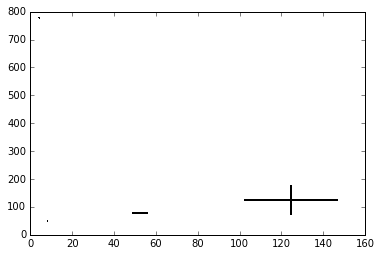

In [23]:
import matplotlib.pyplot as plt

x = [124.46, 8.20, 52.55, 4.33]
y = [124.46, 50.2, 78.3, 778.8]
xerr = [54.2, 0.1, 2.41, 1.78]
yerr = [22.55, 0.37, 3.77, 0.14]

plt.errorbar(x, y, xerr, yerr, capsize=0, ls='none', color='black', 
            elinewidth=2)

plt.show()

<Container object of 3 artists>

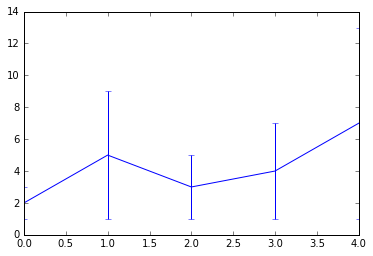

In [33]:
import numpy as np
import matplotlib.pyplot as plt

plt.errorbar(xrange(5), [2,5,3,4,7], yerr=[1,4,2,3,6])

In [31]:
import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

# a = [[5, 4, 7], [5, 4, 8]]
# a1 = [arr[0] for arr in np.array(a)]
# print 'a1 =', a1
# b = np.array([6, 5, 9])
# c = b - a
# print 'c =', c

# m = np.array((1, 3, 10, 5))
# a = 6
# m2 = m < a
# print 'm2 =', m2
# m3 = m - m2
# print 'm3 =', m3

# file_name = 'NGC1333_NH3_11_DR1.fits'
# print '[arr[0] for arr in np.array(lines_margins[file_name])] =', [np.abs(arr[0]-arr[1]) for arr in np.array(lines_margins[file_name])]
# widths_of_all_lines = [arr[0] for arr in np.array(lines_margins[file_name])] - [arr[1] for arr in np.array(lines_margins[file_name])]
# sum_line_widths = np.sum(widths_of_all_lines)


# np.sum([[0, 1], [0, 5]], axis=0)
# array([0, 6])


# this_lines_margins = np.array(lines_margins[file_name]))
# # np.sum()

a = [[-4, -1], [-1,1], [1,7]]
widths = [np.abs(arr[0]-arr[1]) for arr in a]
widths
b = sum(widths)
b

11

In [23]:
    
print table_names

['map', 'bin width', 'bin#', 'T_med', 'NH3', 'NH3_err', 'NH3_22', 'NH3_22_err', 'NH3_33', 'NH3_33_err', 'C2S', 'C2S_err', 'HC5N', 'HC5N_err', 'HC7N_21_20', 'HC7N_21_20_err', 'HC7N_22_2', 'HC7N_22_2_err']
